In [1]:
import numpy as np
from numpy.random import randint
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mn
import matplotlib
from numpy.linalg import inv
%matplotlib inline

In [2]:
I = np.array([[1, 0], [0, 1]])
blue_mean_rv = mn([1, 0], I)
red_mean_rv = mn([0, 1], I)
blue_rv = [mn(blue_mean_rv.rvs(), I/5) for _ in range(10)]
red_rv = [mn(red_mean_rv.rvs(), I/5) for _ in range(10)]
rvs = {'blue': blue_rv, 'red': red_rv}

In [3]:
def classifier(model, x):
    return model(x) > 0.5

In [4]:
def bayes(x):
    pr, pb = 0, 0
    for r in rvs['blue']:
        pb += r.pdf(x)
    for r in rvs['red']:
        pr += r.pdf(x)
    return pr/(pb+pr)

In [5]:
X, Y = np.zeros(shape=(10200, 2)), np.zeros(shape=(10200, 1))
for i in range(10200):
    X[i] = rvs[('blue','red')[i%2]][randint(10)].rvs()
    Y[i] = i%2
X_train, X_test = X[:200,:], X[200:,:]
Y_train, Y_test = Y[:200,:], Y[200:,:]

In [6]:
x_min = np.amin(X, axis=0)
x_max = np.amax(X, axis=0)

In [7]:
x1_grid, x2_grid = np.meshgrid(np.linspace(x_min[0], x_max[0], 100),
                               np.linspace(x_min[1], x_max[1], 100))

def fill_grid(model):
    y_grid = np.zeros(shape=x1_grid.shape)
    for i in range(100):
        for j in range(100):
            y_grid[i, j] = classifier(model, [x1_grid[i,j], x2_grid[i,j]])    
    return y_grid

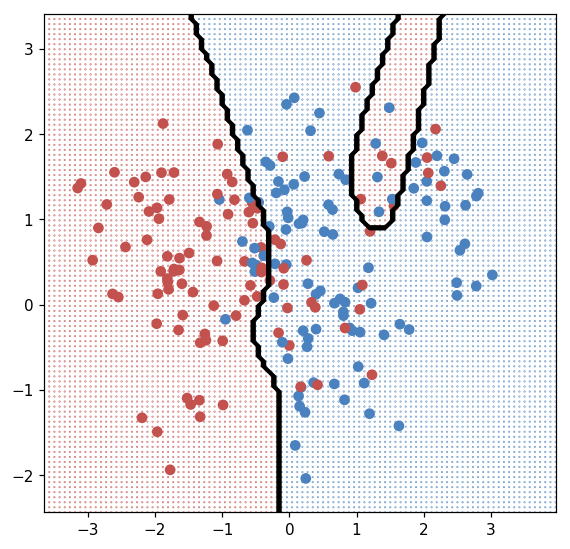

In [8]:
def plot_decision_boundary(model):
    y_grid = fill_grid(model)
    fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
    cmap = matplotlib.colors.ListedColormap(['#4A81BF', '#C3514E'])
    ax1.contour(x1_grid, x2_grid, y_grid, colors='black', linewidths=1)
    ax1.scatter(x1_grid, x2_grid, c=y_grid, s=0.1, cmap=cmap)
    ax1.scatter(X_train[:,0], X_train[:,1], c=Y_train[:,0], cmap=cmap)
    ax1.set_xlim(x_min[0], x_max[0])
    ax1.set_ylim(x_min[1], x_max[1])
    
plot_decision_boundary(bayes)

In [9]:
def hat(model, X):
    Y_hat = np.zeros(shape=(X.shape[0], 1))
    for i in range(X.shape[0]):
        Y_hat[i] = model(X[i])
    return Y_hat

In [10]:
def mse(model, X, Y):
    Y_hat = hat(model, X)
    return ((Y - Y_hat).T.dot(Y - Y_hat)/X.shape[0])[0,0]

In [11]:
mse(bayes, X_test, Y_test)

0.13201377559234465

In [12]:
X, Y = np.ones(shape=(200, 3)), Y_train
X[:,1:] = X_train

In [13]:
b = inv((X.T.dot(X))).dot(X.T).dot(Y).squeeze()
def linear(x):
    return b.dot(np.array([1, x[0], x[1]]))

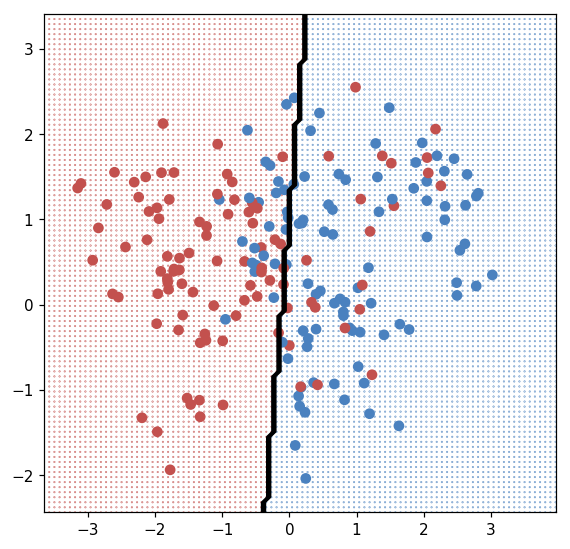

In [14]:
plot_decision_boundary(linear)

In [15]:
mse(linear, X_test, Y_test)

0.1746874507197823

In [16]:
k = 4
def k_means(x):
    return np.mean(Y_train[((X_train[:,0]-x[0])**2 + (X_train[:,1]-x[1])**2).argsort()[:k]])

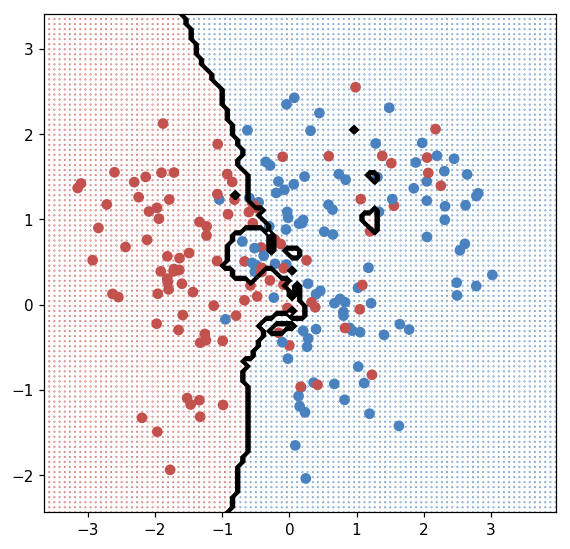

In [17]:
plot_decision_boundary(k_means)

In [18]:
degrees_of_freedom = []
train_error, test_error = [], []
for k in range(1, 200):
    degrees_of_freedom.append(200/k)
    train_error.append(mse(k_means, X_train, Y_train))
    test_error.append(mse(k_means, X_test, Y_test))

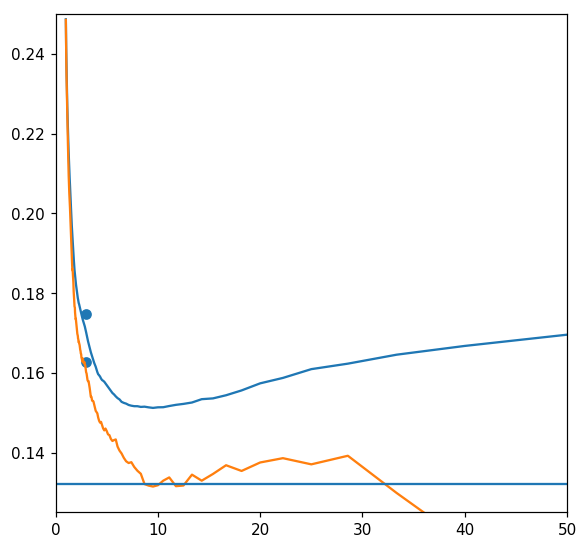

In [19]:
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
ax1.plot(degrees_of_freedom, test_error)
ax1.plot(degrees_of_freedom, train_error)
ax1.axhline(mse(bayes, X_test, Y_test))
ax1.set_xlim(0, 50)
ax1.set_ylim(0.125, 0.25)
ax1.scatter([3, 3], [mse(linear, X_test, Y_test), mse(linear, X_train, Y_train)])

In [20]:
from sklearn.model_selection import train_test_split

X = np.linspace(-1, 1, 100)
Y = np.sin(np.pi*X)

def do_random_fit(k):
    X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.8)
    X_train += np.random.normal(0, 0.1, len(X_train))
    X_train_ = np.ones(shape=(len(X_train), 10))
    X_ = np.ones(shape=(len(X), 10))
    for i in range(10):
        X_train_[:,i] = X_train**i
        X_[:,i] = X**i
    Xx = X_train_[:,:k]
    b = inv((Xx.T.dot(Xx))).dot(Xx.T).dot(Y_train)
    Y_hat = b.dot(X_[:,:k].T)
    return Y_hat

(-1.2, 1.2)

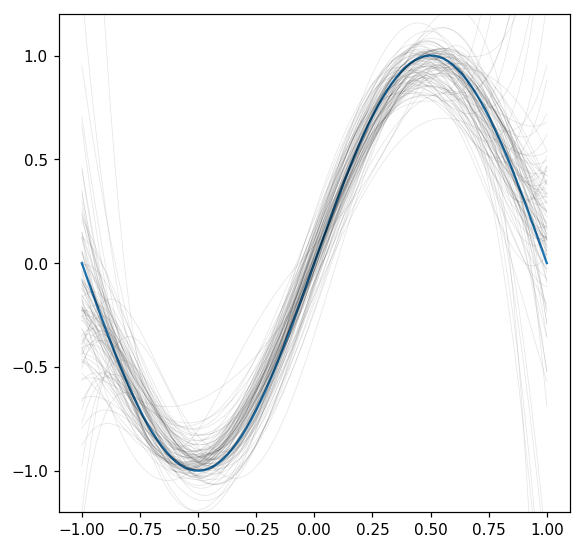

In [21]:
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
ax1.plot(X, Y)
#ax1.scatter(X_train, Y_train)
for i in range(100):
    Y_hat = do_random_fit(6)
    ax1.plot(X, Y_hat, linewidth=0.5, color='black', alpha=0.1)
ax1.set_ylim(-1.2, 1.2)

In [22]:
k_mse = []
for k in range(9):
    mse = []
    for i in range(100):
        Y_hat = do_random_fit(k)
        mse.append(np.mean((Y_hat - Y)**2))
    k_mse.append(np.mean(mse))

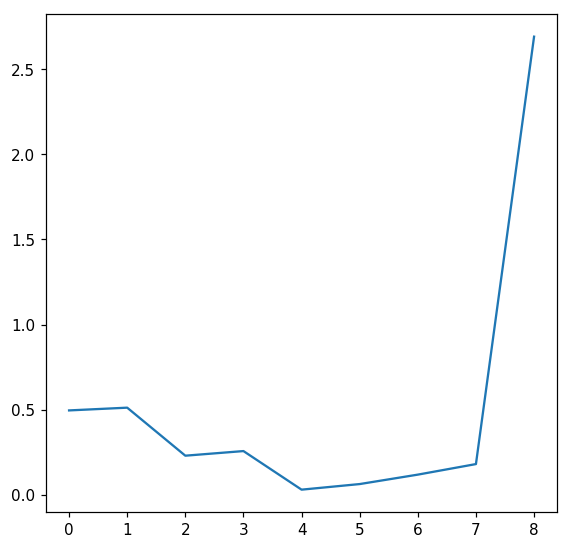

In [23]:
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
ax1.plot(range(9), k_mse)

In [24]:
from numpy.random import uniform
mse, var, bis, dis = [], [], [], []

for dims in range(1, 11):
    N, p, sims = 1000, dims, 1000
    y_hat = np.zeros(shape=(sims, 1))
    dist = np.zeros(shape=(sims))

    for s in range(sims):
        X = uniform(-1, 1, (N,p))
        Xs = np.zeros(shape=(N))
        Y = np.zeros(shape=(N, 1))
        for i in range(N):
            Xs[i] = X[i, :].dot(X[i, :])
            Y[i, 0] = np.exp(-8*X[i, :].dot(X[i, :]))    
        min_i = np.argmin(Xs)
        dist[s] = np.sqrt(Xs[min_i])
        y_hat[s][0] = Y[min_i]
    mse.append(np.mean((1-y_hat)**2))
    var.append(np.mean((y_hat - np.mean(y_hat))**2))
    bis.append((np.mean(y_hat)-1)**2)
    dis.append(np.mean(dist))

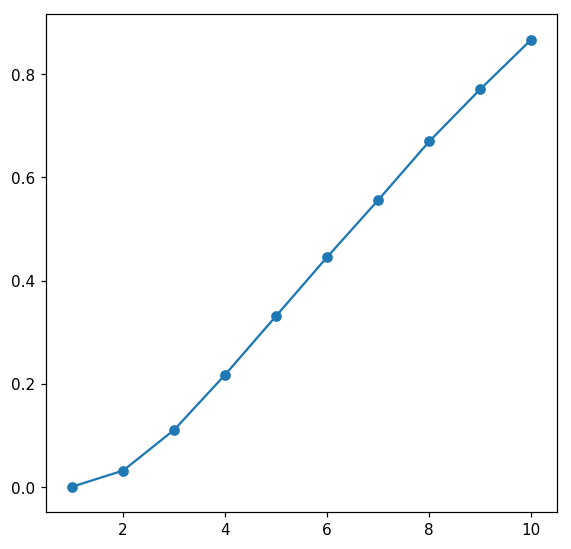

In [25]:
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
ax1.plot(range(1,11), dis)
ax1.scatter(range(1,11), dis)

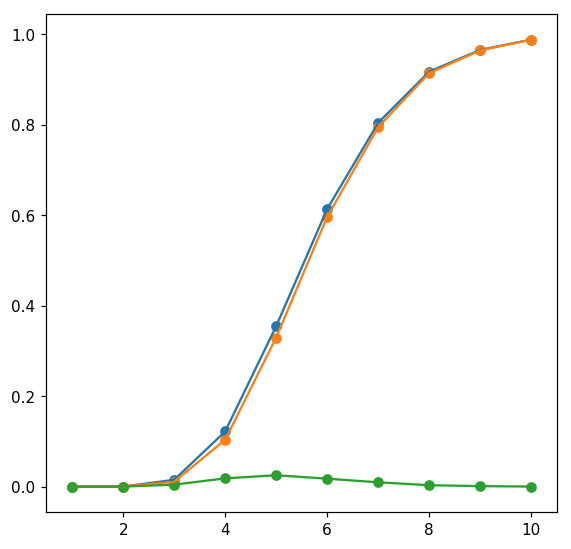

In [26]:
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
ax1.plot(range(1,11), mse)
ax1.scatter(range(1,11), mse)
ax1.plot(range(1,11), bis)
ax1.scatter(range(1,11), bis)
ax1.plot(range(1,11), var)
ax1.scatter(range(1,11), var)

In [27]:
mse, var, bis, dis = [], [], [], []

for dims in range(1, 11):
    N, p, sims = 1000, dims, 1000
    y_hat = np.zeros(shape=(sims, 1))
    dist = np.zeros(shape=(sims))

    for s in range(sims):
        X = uniform(-1, 1, (N,p))
        Xs = np.zeros(shape=(N))
        Y = np.zeros(shape=(N, 1))
        for i in range(N):
            Xs[i] = X[i, :].dot(X[i, :])
            Y[i, 0] = 0.5*(X[i,0]+1)**3
        min_i = np.argmin(Xs)
        dist[s] = np.sqrt(Xs[min_i])
        y_hat[s][0] = Y[min_i]
    mse.append(np.mean((0.5-y_hat)**2))
    var.append(np.mean((y_hat - np.mean(y_hat))**2))
    bis.append((np.mean(y_hat)-0.5)**2)
    dis.append(np.mean(dist))

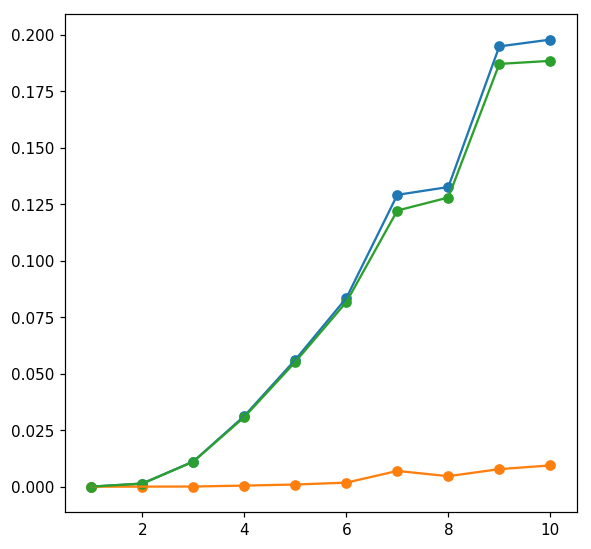

In [28]:
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
ax1.plot(range(1,11), mse)
ax1.scatter(range(1,11), mse)
ax1.plot(range(1,11), bis)
ax1.scatter(range(1,11), bis)
ax1.plot(range(1,11), var)
ax1.scatter(range(1,11), var)

In [39]:
b = 5
s = 1
X = np.linspace(-1, 1, 100)
Y = b*X + np.random.normal(0, s, len(X))
N = 10
X_train = uniform(-1, 1, (N, 1))
E_train = np.random.normal(0, s, (N, 1))
Y_train = b*X_train + E_train
b_hat = inv(X_train.T.dot(X_train)).dot(X_train.T).dot(Y_train)
b_hat

array([[4.34035905]])

In [58]:
#Y_hat = X_train.dot(b_hat)
#X_train.dot([[5]])+
x0 = 0.5
Y_hat = x0*np.squeeze(b_hat)
Y_hat - np.sum(np.squeeze(X_train.dot(inv(X_train.T.dot(X_train)))*x0)*np.squeeze(E_train))

2.5

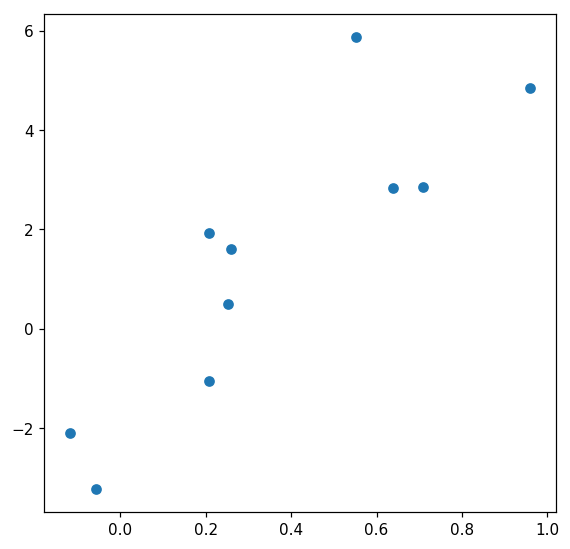

In [33]:
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=110)
ax1.scatter(X_train, Y_train)